In [19]:
from autox import AutoTS

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [21]:
label = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件1-区域15分钟负荷数据.csv")
industry = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件2-行业日负荷数据.csv")
weather = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件3-气象数据.csv")

In [22]:
weather['白天风力风向'].unique()

array(['无持续风向<3级', '北风4～5级', '微风<3级', '北风3', '东北风3～4级', '北风3～4级',
       '南风3～4级', '南风4～5级', '东北偏东风2', '无持续风向微风', '无持续风向1-2级', '东风3-4级',
       '东南风4-5级', '东风3～4级', '东北风3-4级', '东风8-9级', '东南风3-4级', '北风3-4级',
       '北风4-5级', '南风3-4级', '南风1-2级', '东南风1-2级', '西南风3-4级', '东风1-2级',
       '北风1-2级', '东北风1-2级', '西南风1-2级'], dtype=object)

In [23]:
weather['夜晚风力风向'].unique()

array(['无持续风向<3级', '北风4～5级', '北风3～4级', '微风<3级', '北风3', '东北偏东风2',
       '无持续风向微风', '无持续风向1-2级', '东风3-4级', '东南风4-5级', '东南风3～4级', '东北风3-4级',
       '东风8-9级', '东南风3-4级', '北风3-4级', '北风4-5级', '南风3-4级', '南风1-2级',
       '东南风1-2级', '西南风3-4级', '东风1-2级', '北风1-2级', '东北风1-2级', '西南风1-2级'],
      dtype=object)

# 数据清洗

In [24]:
weather['最高温度'] = weather['最高温度'].map(lambda d: d.replace('℃','')).astype(int)
weather['最低温度'] = weather['最低温度'].map(lambda d: d.replace('℃','')).astype(int)
weather['start_weather'] = weather['天气状况'].apply(lambda x: x.split('/')[0])
weather['end_weather'] = weather['天气状况'].apply(lambda x: x.split('/')[1])

dic1 = {'晴':0,'晴间多云':1, '多云':2, '局部多云':2,'阴':3 ,'雾':4, '小雨':5, '小到中雨':6, '小雨-中雨':6, '中雨':7, '阵雨':8,
 '中雨-大雨':9, '中到大雨':9, '大雨':10,'雷阵雨':11, '大到暴雨':12, '暴雨':13}
dic2 = {'无持续风向<3级':3, '北风4～5级':6, '微风<3级':3, '北风3':4, '东北风3～4级':5, '北风3～4级':5,
       '南风3～4级':5, '南风4～5级':6, '东北偏东风2':2, '无持续风向微风':0, '无持续风向1-2级':1, '东风3-4级':5,
       '东南风4-5级':6, '东风3～4级':5, '东北风3-4级':5, '东风8-9级':7, '东南风3-4级':5, '北风3-4级':5,
       '北风4-5级':6, '南风3-4级':5, '南风1-2级':1, '东南风1-2级':1, '西南风3-4级':5, '东风1-2级':1,
       '北风1-2级':1, '东北风1-2级':1, '西南风1-2级':1}
dic3 = {'无持续风向<3级':3, '北风4～5级':6, '北风3～4级':5, '微风<3级':3, '北风3':4, '东北偏东风2':2,
       '无持续风向微风':0, '无持续风向1-2级':1, '东风3-4级':5, '东南风4-5级':6, '东南风3～4级':5, '东北风3-4级':5,
       '东风8-9级':7, '东南风3-4级':5, '北风3-4级':5, '北风4-5级':6, '南风3-4级':5, '南风1-2级':1,
       '东南风1-2级':1, '西南风3-4级':5, '东风1-2级':1, '北风1-2级':1, '东北风1-2级':1, '西南风1-2级':1}

weather['start_weather']=weather['start_weather'].map(dic1)
weather['end_weather']=weather['end_weather'].map(dic1)
weather['白天风力风向']=weather['白天风力风向'].map(dic2)
weather['夜晚风力风向']=weather['夜晚风力风向'].map(dic3)

In [25]:
weather['温差'] = weather['最高温度']-weather['最低温度']

In [26]:
weather = weather.drop_duplicates(['日期'])

# 查看缺失值

In [27]:
import missingno as msn
from pylab import *
from matplotlib.font_manager import FontProperties  
import matplotlib.pyplot as plt  
#支持中文
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [28]:
label = label.rename(columns={'数据时间':'日期1'})
label['日期'] = label['日期1'].apply(lambda x: x.split(' ')[0])
weather.loc[:, '日期'] = pd.to_datetime(weather.loc[:, '日期'], format='%Y年%m月%d日', errors='coerce')
label.loc[:, '日期'] = pd.to_datetime(label.loc[:, '日期'], format='%Y/%m/%d', errors='coerce')

In [29]:
train = label.merge(weather,on='日期',how='left')

In [30]:
train['日期1'] = pd.to_datetime(train['日期1'])

In [31]:
train.columns

Index(['日期1', '总有功功率（kw）', '日期', '天气状况', '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差'],
      dtype='object')

In [32]:
train['minute']  = train['日期1'].dt.minute

In [33]:
train['minute'] =1

In [34]:
train 

日期1    总有功功率（kw）         日期    天气状况  最高温度  最低温度  \
0      2018-01-01 00:00:00  244033.7682 2018-01-01   多云/多云    22    12   
1      2018-01-01 00:15:00  232720.6402 2018-01-01   多云/多云    22    12   
2      2018-01-01 00:30:00  231685.6891 2018-01-01   多云/多云    22    12   
3      2018-01-01 00:45:00  227581.3317 2018-01-01   多云/多云    22    12   
4      2018-01-01 01:00:00  233482.4269 2018-01-01   多云/多云    22    12   
...                    ...          ...        ...     ...   ...   ...   
128151 2021-08-31 22:45:00  202409.1270 2021-08-31  雷阵雨/阵雨    32    26   
128152 2021-08-31 23:00:00  218576.4635 2021-08-31  雷阵雨/阵雨    32    26   
128153 2021-08-31 23:15:00  200112.5091 2021-08-31  雷阵雨/阵雨    32    26   
128154 2021-08-31 23:30:00  199865.5937 2021-08-31  雷阵雨/阵雨    32    26   
128155 2021-08-31 23:45:00  198483.5592 2021-08-31  雷阵雨/阵雨    32    26   

        白天风力风向  夜晚风力风向  start_weather  end_weather  温差  minute  
0            3       3              2            2  10       1  
1            3       3              2            2  10       1  
2            3       3              2            2  10       1  
3            3       3              2            2  10       1  
4            3       3              2            2  10       1  
...        ...     ...            ...          ...  ..     ...  
128151       1       1             10            8   6       1  
128152       1       1             10            8   6       1  
128153       1       1             10            8   6       1  
128154       1       1             10            8   6       1  
128155       1       1             10            8   6       1  

[128156 rows x 12 columns]

# 模型验证(选择)

In [36]:
train1 = train[125000:len(train)-960]

In [2]:
autots = AutoTS(df = train1,
                id_col = 'minute',
                time_col = '日期1',
                target_col = '总有功功率（kw）',
                time_varying_cols = ['最高温度', '最低温度', '温差','白天风力风向', '夜晚风力风向', 'start_weather','end_weather','总有功功率（kw）'],
                time_interval_num = 15,
                time_interval_unit = 'minute',
                forecast_period = 960,
                mode = 'cnn',
                metric = 'mae')

sub = autots.get_result()
import numpy as np
from sklearn import metrics 
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(train[len(train)-960:].reset_index()['总有功功率（kw）'])
y_pred = np.array(sub['总有功功率（kw）'])
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))

In [1]:
autots = AutoTS(df = train1,
                id_col = 'minute',
                time_col = '日期1',
                target_col = '总有功功率（kw）',
                time_varying_cols = ['最高温度', '最低温度', '温差','总有功功率（kw）'],
                time_interval_num = 15,
                time_interval_unit = 'minute',
                forecast_period = 960,
                mode = 'cnn',
                metric = 'mae')

sub = autots.get_result()
import numpy as np
from sklearn import metrics 
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(train[len(train)-960:].reset_index()['总有功功率（kw）'])
y_pred = np.array(sub['总有功功率（kw）'])
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))

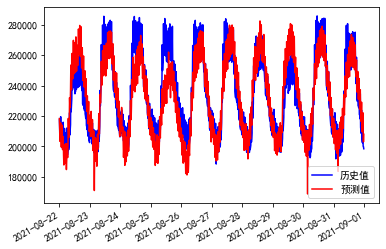

In [35]:
df = train[len(train)-960:len(train)]
import matplotlib.pyplot as plt
cur = 1
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# df = df[df['总有功功率（kw）']>150000.22022061236]
df = df.fillna(df.mean())
plt.plot(df.loc[df['minute'] == cur, '日期1'], df.loc[df['minute'] == cur, '总有功功率（kw）'],label='图例',color = 'b')
plt.plot(sub.loc[sub['minute'] == cur, '日期1'], sub.loc[sub['minute'] == cur, '总有功功率（kw）'], label='图例1',color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
plt.savefig(r'C:\Users\18484\Desktop\自己的泰迪杯支撑材料\问题一预测结果精度\CNN预测结果3.jpg',dpi=400)
plt.show()

In [48]:
import numpy as np
from sklearn import metrics 
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(train[len(train)-960:].reset_index()['总有功功率（kw）'])
y_pred = np.array(sub['总有功功率（kw）'])
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))

MSE: 114991338.05071329
RMSE: 10723.401421690474
MAE: 8340.4987346875
MAPE: 0.035541875988866094


# 未标准化精度分析

In [28]:
import numpy as np
from sklearn import metrics 
from sklearn.metrics import r2_score#R square
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(train[len(train)-960:].reset_index()['总有功功率（kw）'])
y_pred = np.array(sub['总有功功率（kw）'])
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))

MSE: 141839523.44822842
RMSE: 11909.639937807877
MAE: 9153.467480963542
MAPE: 0.03872858765223809
R方: 0.7749126433808122


# 标准化后精度分析

In [23]:
import numpy as np
from sklearn import metrics 
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(train[128732-960:].reset_index()['总有功功率（kw）'])
y_pred = np.array(sub['总有功功率（kw）'])
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))


MSE: 0.10288147524179458
RMSE: 0.3207514228211538
MAE: 0.27368818222613445
MAPE: 2.7786284514167847


# 进行训练预测未来10天每15分钟值

In [3]:
# autots = AutoTS(df = train[100000:],
#                 id_col = 'minute',
#                 time_col = '日期1',
#                 target_col = '总有功功率（kw）',
#                 time_varying_cols = ['最高温度', '最低温度', '白天风力风向', '夜晚风力风向', 'start_weather','end_weather','总有功功率（kw）'],
#                 time_interval_num = 15,
#                 time_interval_unit = 'minute',
#                 forecast_period = 96*91,
#                 mode = 'cnn',
#                 metric = 'mae')

# sub = autots.get_result()

<AxesSubplot:>

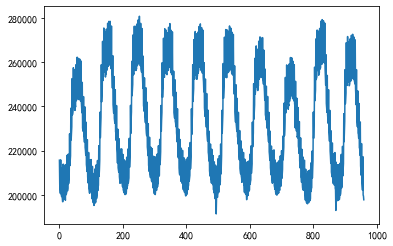

In [39]:
sub.rename(columns={'日期1':'数据时间'})['总有功功率（kw）'].plot()

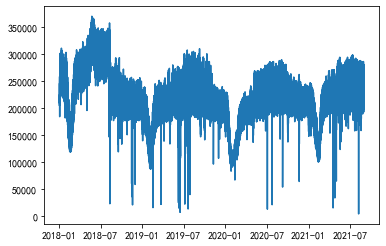

In [57]:
plt.plot(train['日期1'],train['总有功功率（kw）'])
plt.savefig('所有值得时序图.jpg',dpi=100)

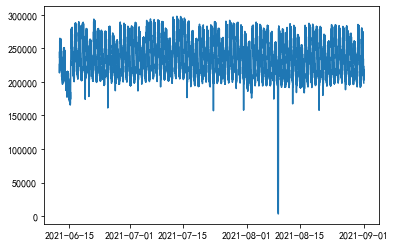

In [56]:
plt.plot(train[121000:]['日期1'],train[121000:]['总有功功率（kw）'])
plt.savefig('选取部分数据时序图.jpg',dpi=100)

In [95]:
sub1 = sub.rename(columns={'日期1':'数据时间'})

In [96]:
sub1

minute                数据时间      总有功功率（kw）
0         1 2021-09-01 00:00:00  212069.390625
1         1 2021-09-01 00:15:00  200688.140625
2         1 2021-09-01 00:30:00  199017.437500
3         1 2021-09-01 00:45:00  197826.921875
4         1 2021-09-01 01:00:00  211140.234375
..      ...                 ...            ...
955       1 2021-09-10 22:45:00  203313.765625
956       1 2021-09-10 23:00:00  216722.359375
957       1 2021-09-10 23:15:00  201207.812500
958       1 2021-09-10 23:30:00  198770.703125
959       1 2021-09-10 23:45:00  197190.640625

[960 rows x 3 columns]

# 保存结果

In [97]:
sub1[['数据时间','总有功功率（kw）']].to_csv('第一答问第一小问.csv',index=0)

# 可视化

In [93]:
df = train[125000:]

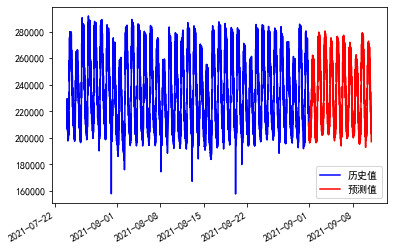

In [104]:

cur = 1
df = df[df['总有功功率（kw）']>150000.22022061236]
df = df.fillna(df.mean())
plt.plot(df.loc[df['minute'] == cur, '日期1'], df.loc[df['minute'] == cur, '总有功功率（kw）'],label='图例',color = 'b')
plt.plot(sub.loc[sub['minute'] == cur, '日期1'], sub.loc[sub['minute'] == cur, '总有功功率（kw）'], label='图例1',color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
plt.savefig('CNN预测结果.jpg',dpi=400)
plt.show()

In [76]:
train[127000:]['总有功功率（kw）'].mean()

230159.22022061236

# 第一大题第二小问

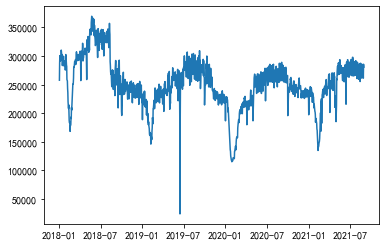

In [40]:
df_max = train.groupby(['日期'])['总有功功率（kw）'].max()
df_max1 = pd.DataFrame(df_max).reset_index()
plt.plot(df_max1['日期'],df_max1['总有功功率（kw）'])
# plt.savefig('第二问每天最大值.jpg',dpi=100)

In [41]:
df_max2 = df_max1.merge(weather,on='日期',how='left')

In [42]:
df_max2['minute']=1

In [43]:
df_max2 

日期    总有功功率（kw）     天气状况  最高温度  最低温度  白天风力风向  夜晚风力风向  \
0    2018-01-01  257733.9648    多云/多云    22    12       3       3   
1    2018-01-02  288502.5947    多云/多云    22    15       3       3   
2    2018-01-03  300698.5858     多云/阴    23    15       3       3   
3    2018-01-04  293806.5077    多云/小雨    21    16       3       3   
4    2018-01-05  295075.2147     阴/小雨    19    13       3       3   
...         ...          ...      ...   ...   ...     ...     ...   
1334 2021-08-27  283786.5080  雷阵雨/雷阵雨    35    26       1       1   
1335 2021-08-28  272522.5991   雷阵雨/多云    33    26       1       1   
1336 2021-08-29  261364.9171  雷阵雨/雷阵雨    32    25       1       1   
1337 2021-08-30  285669.1430    阵雨/阵雨    34    26       1       1   
1338 2021-08-31  280565.9749   雷阵雨/阵雨    32    26       1       1   

      start_weather  end_weather  温差  minute  
0                 2            2  10       1  
1                 2            2   7       1  
2                 2            3   8       1  
3                 2            5   5       1  
4                 3            5   6       1  
...             ...          ...  ..     ...  
1334             10           10   9       1  
1335             10            2   7       1  
1336             10           10   7       1  
1337              8            8   8       1  
1338             10            8   6       1  

[1339 rows x 11 columns]

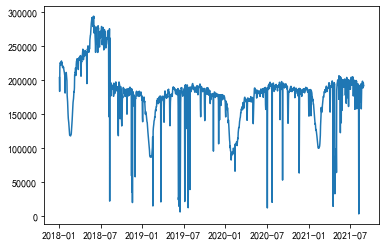

In [44]:
df_min = train.groupby(['日期'])['总有功功率（kw）'].min()
df_min1 = pd.DataFrame(df_min).reset_index()
plt.plot(df_min1['日期'],df_min1['总有功功率（kw）'])
plt.savefig('第二问每天最小值.jpg',dpi=100)

In [45]:
df_min2 = df_min1.merge(weather,on='日期',how='left')

In [46]:
df_min2['minute']=1

In [60]:
autots = AutoTS(df = df_max2[:len(df_max2)-91],
                id_col = 'minute',
                time_col = '日期',
                target_col = '总有功功率（kw）',
                time_varying_cols = ['最高温度', '最低温度','总有功功率（kw）'],
                time_interval_num = 24*60,
                time_interval_unit = 'minute',
                forecast_period = 91,
                mode = 'cnn',
                metric = 'mae')

sub = autots.get_result()

   INFO ->  [+] feature engineer
   INFO ->  [+] fe_time
   INFO ->  [+] fe_onehot
   INFO ->  [+] feature combination
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1024.38it/s]
   INFO ->  [+] normalization
   INFO ->  [+] build data
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]
   INFO ->  [+] training model


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 91, 3)]      0           []                               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 91, 50)       350         ['input_17[0][0]']               
                                                                                                  
 conv1d_17 (Conv1D)             (None, 91, 50)       5050        ['conv1d_16[0][0]']              
                                                                                                  
 dense_24 (Dense)               (None, 91, 1)        51          ['conv1d_17[0][0]']              
                                                                                           

   INFO ->  [+] predict
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.52it/s]


# 只用了20000条数据(两种预测方法,先选出每天最值，再预测，或者直接预测未来在选取最值)

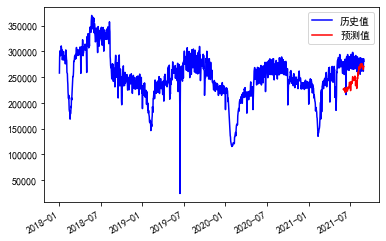

In [61]:
df = df_max2
plt.plot(df.loc[df['minute'] == 1, '日期'], df.loc[df['minute'] == 1, '总有功功率（kw）'], color = 'b')
plt.plot(sub.loc[sub['minute'] == 1, '日期'], sub.loc[sub['minute'] == 1, '总有功功率（kw）'], color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
# plt.savefig('CNN第二小问最大值预测结果.jpg',dpi=400)
plt.show()

In [62]:
import numpy as np
from sklearn import metrics 
from sklearn.metrics import r2_score#R square
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(df_max2[len(df_max2)-91:].reset_index()['总有功功率（kw）'])
y_pred = np.array(sub['总有功功率（kw）'])
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))

MSE: 1624857848.5200105
RMSE: 40309.52553082225
MAE: 35901.947209615384
MAPE: 0.12725513793352541
R方: -9.46735138679929


In [184]:
sub1 = sub.rename(columns={'日期':'数据时间'})
sub1[['数据时间','总有功功率（kw）']].to_csv('第一大问第二小问.csv',index=0)

In [185]:
sub.rename(columns={'日期1':'数据时间'})

minute         日期      总有功功率（kw）
0        1 2021-09-01  258834.437500
1        1 2021-09-02  263457.937500
2        1 2021-09-03  257568.859375
3        1 2021-09-04  246660.484375
4        1 2021-09-05  248519.859375
..     ...        ...            ...
86       1 2021-11-26  275616.468750
87       1 2021-11-27  266224.500000
88       1 2021-11-28  258210.406250
89       1 2021-11-29  278329.968750
90       1 2021-11-30  269280.156250

[91 rows x 3 columns]

# 每天最小值

In [198]:
df_min2 = pd.read_csv('df_max.csv')

In [199]:
df_min2 

日期           商业        大工业用电        普通工业       非普工业  index  \
0    2019-01-01   64027.8582  117888.3300   6179.9364        NaN    366   
1    2019-01-02   75467.2143  126843.7914  10711.9704        NaN    367   
2    2019-01-03  132776.9442  130286.1294  10079.0262        NaN    368   
3    2019-01-04   97731.1308  133018.6344   9713.3055        NaN    369   
4    2019-01-05  132883.1868  133504.4784   6958.3842        NaN    370   
..          ...          ...          ...         ...        ...    ...   
968  2021-08-27  104728.8762  102950.5320  10332.7482  3207.7014   1340   
969  2021-08-28   93855.1368  107493.4824   6337.3656  2418.1716   1341   
970  2021-08-29   84127.1658   98528.9820   6509.8032  2486.0946   1342   
971  2021-08-30  102851.2758  106633.8348  10606.9374  3316.1904   1343   
972  2021-08-31   96396.2568  101834.8440  10329.5676  3223.6920   1344   

        天气状况  最高温度  最低温度  白天风力风向  夜晚风力风向  start_weather  end_weather  minute  
0        阴/阴    12     7       1       1              3            3       1  
1      小雨/小雨    11     6       1       1              5            5       1  
2      多云/小雨    15     9       1       1              2            5       1  
3       阴/小雨    17    12       1       1              3            5       1  
4       阴/小雨    17    12       1       1              3            5       1  
..       ...   ...   ...     ...     ...            ...          ...     ...  
968  雷阵雨/雷阵雨    35    26       1       1             10           10       1  
969   雷阵雨/多云    33    26       1       1             10            2       1  
970  雷阵雨/雷阵雨    32    25       1       1             10           10       1  
971    阵雨/阵雨    34    26       1       1              8            8       1  
972   雷阵雨/阵雨    32    26       1       1             10            8       1  

[973 rows x 14 columns]

In [201]:
autots = AutoTS(df = df_min2,
                id_col = 'minute',
                time_col = '日期',
                target_col = '大工业用电',
                time_varying_cols = ['最高温度', '最低温度', '白天风力风向', '夜晚风力风向', 'start_weather','end_weather','大工业用电'],
                time_interval_num = 24*60,
                time_interval_unit = 'minute',
                forecast_period = 1,
                mode = 'cnn',
                metric = 'mae')

sub = autots.get_result()

   INFO ->  [+] feature engineer
   INFO ->  [+] fe_time
   INFO ->  [+] fe_onehot
   INFO ->  [+] feature combination
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.82it/s]
   INFO ->  [+] normalization
   INFO ->  [+] build data
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]
   INFO ->  [+] training model


Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1, 7)]       0           []                               
                                                                                                  
 conv1d_32 (Conv1D)             (None, 1, 50)        750         ['input_33[0][0]']               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 1, 50)        5050        ['conv1d_32[0][0]']              
                                                                                                  
 dense_48 (Dense)               (None, 1, 1)         51          ['conv1d_33[0][0]']              
                                                                                           

   INFO ->  [+] predict
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s]


In [195]:
df = df_min2
plt.plot(df.loc[df['minute'] == 1, '日期'], df.loc[df['minute'] == 1, '总有功功率（kw）'], color = 'b')
plt.plot(sub.loc[sub['minute'] == 1, '日期'], sub.loc[sub['minute'] == 1, '总有功功率（kw）'], color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
plt.savefig('CNN第二小问最小值预测结果.jpg',dpi=400)
plt.show()

In [196]:
sub1 = sub.rename(columns={'日期':'数据时间'})
sub1[['数据时间','总有功功率（kw）']].to_csv('第一大问第二小问最小值.csv',index=0)